In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

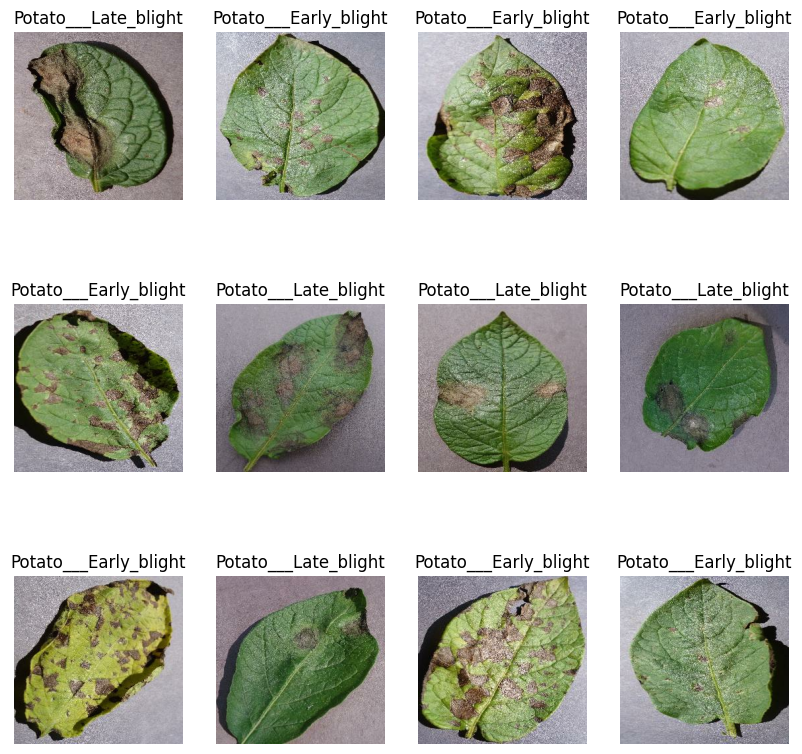

In [18]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1) :
    for i in range(12) :
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [29]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [30]:
train_ds = dataset.take(54)
len(train_ds)

54

In [31]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [32]:
validation_size = 0.1
len(dataset) * validation_size

6.800000000000001

In [33]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [34]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [42]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000) :
    """Splitting datasets in train set, validation set and test set"""
    ds_size = len(ds)
    if shuffle :
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [43]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [44]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [45]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)  #this will read image from disk and then for next iteration when we need the image it will keep that image in the memory
#improves performance of our pipeline
#pretech will load the next set of batch from our disk when if GPU is busy training; improving performance
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [49]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [50]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [52]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

C:\Users\TATHAGATA GHOSH\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 2304)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [56]:
EPOCHS = 50

In [58]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.4643 - loss: 0.9507 - val_accuracy: 0.4583 - val_loss: 0.9353
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5972 - loss: 0.7933 - val_accuracy: 0.8385 - val_loss: 0.5602
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8275 - loss: 0.4782 - val_accuracy: 0.8333 - val_loss: 0.4891
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8637 - loss: 0.3884 - val_accuracy: 0.8646 - val_loss: 0.3223
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 997ms/step - accuracy: 0.8800 - loss: 0.2931 - val_accuracy: 0.9167 - val_loss: 0.2051
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 53s 975ms/step - accuracy: 0.8972 - loss: 0.2386 - val_accuracy: 0.8646 - val_loss: 0.3918
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8793 - loss: 0.3118 - val_accuracy: 0.8385 - val_loss: 0.6723
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9094 - loss: 0.2310 - val_accuracy: 0.9271 - va

In [59]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 328ms/step - accuracy: 0.9895 - loss: 0.0361


In [60]:
scores

[0.04148544743657112, 0.984375]

In [61]:
history

In [62]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [63]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [64]:
history.history['accuracy']

[0.5150462985038757,
 0.6938657164573669,
 0.8420138955116272,
 0.8559027910232544,
 0.8894675970077515,
 0.9120370149612427,
 0.9027777910232544,
 0.9288194179534912,
 0.9351851940155029,
 0.9334490895271301,
 0.9369212985038757,
 0.9461805820465088,
 0.9548611044883728,
 0.9629629850387573,
 0.9600694179534912,
 0.9328703880310059,
 0.9589120149612427,
 0.9722222089767456,
 0.9646990895271301,
 0.9403935074806213,
 0.9675925970077515,
 0.9623842835426331,
 0.9722222089767456,
 0.9716435074806213,
 0.9693287014961243,
 0.9646990895271301,
 0.9739583134651184,
 0.9745370149612427,
 0.9675925970077515,
 0.9716435074806213,
 0.9809027910232544,
 0.9716435074806213,
 0.9774305820465088,
 0.9837962985038757,
 0.9814814925193787,
 0.9861111044883728,
 0.9837962985038757,
 0.9820601940155029,
 0.9803240895271301,
 0.9855324029922485,
 0.9606481194496155,
 0.9809027910232544,
 0.9878472089767456,
 0.9884259104728699,
 0.9895833134651184,
 0.984375,
 0.9942129850387573,
 0.9774305820465088,
 0

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

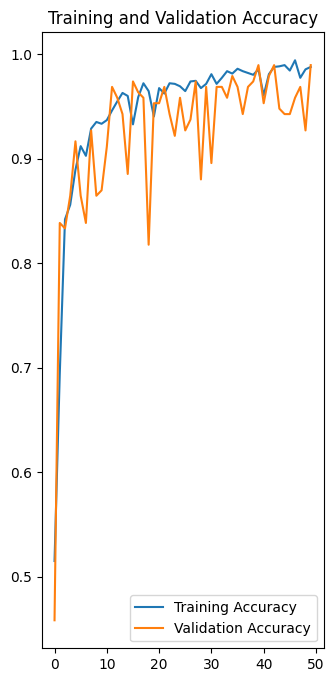

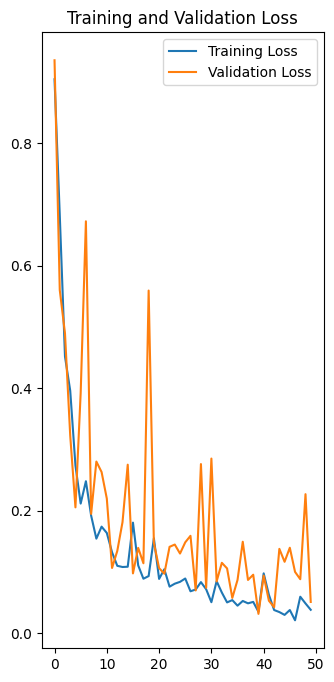

In [69]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label : Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Predicted label : Potato___Late_blight


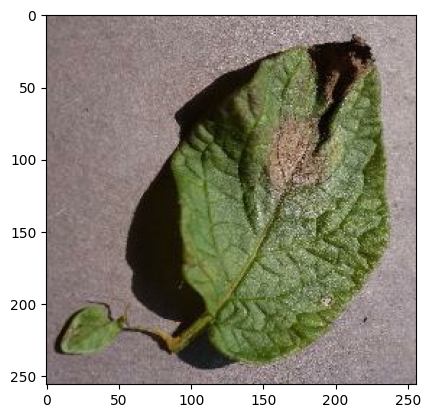

In [89]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1) :
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label :", class_names[first_label])

    batch_prediction = model.predict(images_batch) #prediction for 32 images
    print("Predicted label :", class_names[np.argmax(batch_prediction[0])])  #softmax is a probability; and there are 3 probabilities
    #whatever is the highest probability; that is the class
    #np.argmax gies the index of the highest value


In [90]:
def predict(model, img) :
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


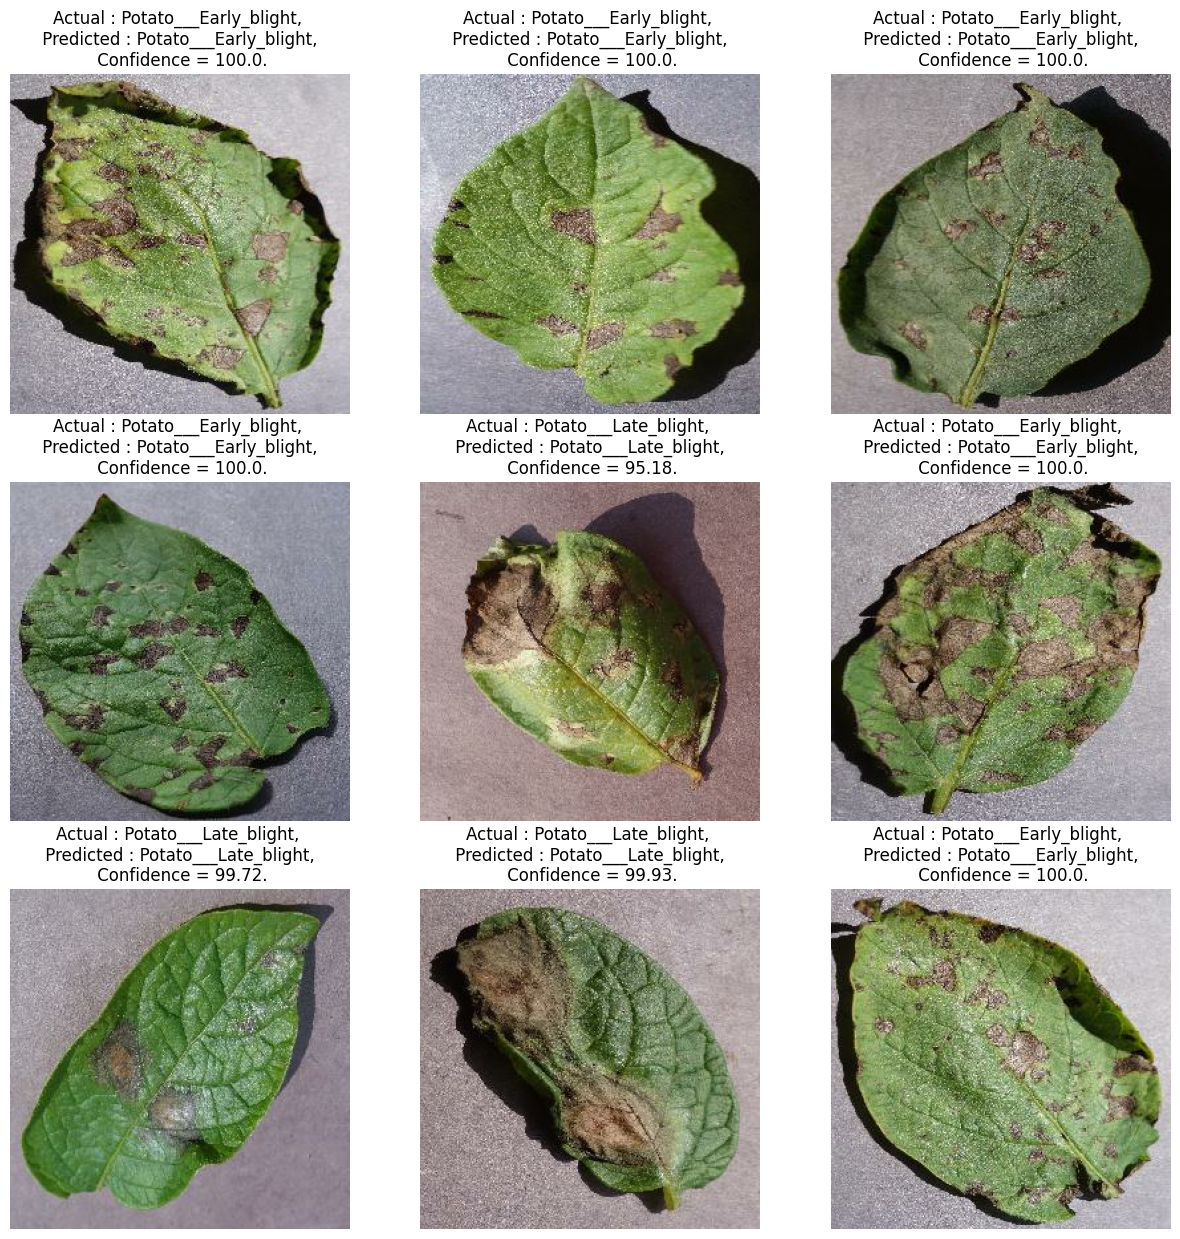

In [95]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1) :
    for i in range(9) :
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class}, \n Predicted : {predicted_class}, \n Confidence = {confidence}.")
        
        plt.axis("off")

In [111]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1 #autoincrement the number of directories on saving different versions of models
model.export(f"../models/{model_version}")

#ran this 3 times for the sake of experiment; the versions are same that are stored in the models directory; will change some things for tomato 

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


Saved artifact at '../models/3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1942095260816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1942095261008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1942095263312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1942095264656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1942095264848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1942095265424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1942095265040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1942095263888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1942095265232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1942200730256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1942200729872: TensorSpec(shape=(), dty